In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly 
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

#something learned new from kaggle

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
from sklearn.metrics import accuracy_score


In [7]:
df = pd.read_csv("data.csv")
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
df.duplicated().sum()

0

In [9]:
#drop target 
#rest are going to be train
numeric= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

cat = df.select_dtypes('object').columns

print(f'Numeric Columns:  {df[numeric].columns}')
print('\n')
print(f'Categories Columns: {df[cat].columns}')

Numeric Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categories Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [10]:
df[cat].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

In [11]:
df[numeric].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


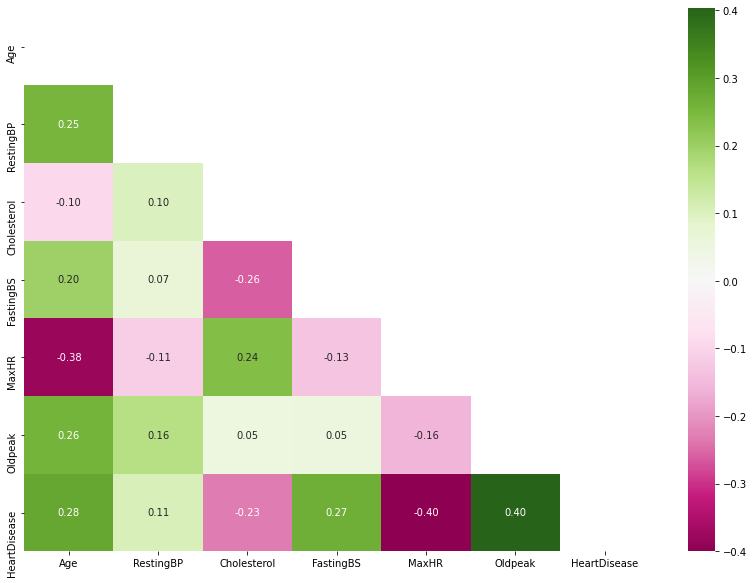

In [12]:

# Calculate correlation between each pair of variable
# Create a dataset
numeric1= df.select_dtypes('number').columns

# Calculate correlation between each pair of variable
matrix = np.triu(df[numeric1].corr())
fig, ax = plt.subplots(figsize=(14,10)) 

# Draw the heatmap with the mask
sns.heatmap (df[numeric1].corr(),   cmap='PiYG',fmt= '.2f',mask=matrix, ax=ax, annot=True);


By above correlation, there is low level correlation between the numeric features and the target variable
-Oldpeak (depression related number) has a positive correlation with the heart disease.
-Maximum heart rate has negative correlation with the heart disease.
-Interestingly cholesterol has negative correlation with the heart disease.

In [13]:
df[cat].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [14]:
def grpby(x):
    z=df.groupby(x)['HeartDisease'].mean().sort_values(ascending=False)
    return z

In [15]:
grpby("Sex")

Sex
M    0.631724
F    0.259067
Name: HeartDisease, dtype: float64

Men are almost 2 and 1/2 times more likely have a heart disease than women.


In [16]:
grpby("ChestPainType")

ChestPainType
ASY    0.790323
TA     0.434783
NAP    0.354680
ATA    0.138728
Name: HeartDisease, dtype: float64

We can observe clear differences among the chest pain type.
-Person with ASY: Asymptomatic chest pain has almost 2 times more likely have a heart disease than person with TA -Typical Angina chest pain.

In [17]:
grpby("RestingECG")

RestingECG
ST        0.657303
LVH       0.563830
Normal    0.516304
Name: HeartDisease, dtype: float64

Here with LVH, Normal- resting ECG results don't have much difference.
But Person with ST: having ST-T wave abnormality is more likely have a heart disease than the others.

In [18]:
grpby('ST_Slope')

ST_Slope
Flat    0.828261
Down    0.777778
Up      0.197468
Name: HeartDisease, dtype: float64

The slope of the peak exercise ST segment has differences.
Up significantly less likely has heart disease than the other two segment.

In [19]:
df.groupby('Oldpeak')['HeartDisease'].mean().sort_values(ascending=False)

Oldpeak
-2.6    1.000000
-2.0    1.000000
 2.1    1.000000
 2.2    1.000000
 2.5    1.000000
 2.8    1.000000
 2.9    1.000000
 3.1    1.000000
 3.2    1.000000
 3.4    1.000000
 3.6    1.000000
 3.7    1.000000
 3.8    1.000000
 4.0    1.000000
 4.4    1.000000
 5.0    1.000000
 5.6    1.000000
 1.7    1.000000
 6.2    1.000000
-1.5    1.000000
-1.0    1.000000
-0.9    1.000000
-0.8    1.000000
-0.7    1.000000
 3.0    0.892857
 2.6    0.857143
 1.8    0.823529
 2.0    0.815789
 1.5    0.792453
 2.4    0.750000
 0.9    0.750000
 1.2    0.730769
 1.1    0.714286
 1.9    0.714286
 1.3    0.714286
 0.7    0.714286
 1.0    0.697674
 1.4    0.666667
 0.5    0.631579
 1.6    0.500000
 4.2    0.500000
 3.5    0.500000
-0.5    0.500000
 0.8    0.500000
 0.1    0.357143
 0.0    0.336957
 0.6    0.285714
 0.3    0.272727
 0.2    0.181818
 0.4    0.181818
-1.1    0.000000
 2.3    0.000000
-0.1    0.000000
Name: HeartDisease, dtype: float64

In [20]:
grpby('ExerciseAngina')

ExerciseAngina
Y    0.851752
N    0.351005
Name: HeartDisease, dtype: float64

In [21]:
grpby('Cholesterol')

Cholesterol
603    1.0
341    1.0
337    1.0
170    1.0
336    1.0
      ... 
227    0.0
302    0.0
344    0.0
347    0.0
215    0.0
Name: HeartDisease, Length: 222, dtype: float64

exercise-induced angina with 'Yes' almost 2.4 times more likley have a heart disaese than exercise-induced angina with 'No'

In [22]:
#with scaler
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=13)

enc= OneHotEncoder()
scl= StandardScaler()

#ColumnTransformer in SciKit instead of LabelEncoding and OneHotEncoding for data preprocessing
#basically combine LabelEncoding and OneHotEncoding into just one line of code. And the result is exactly the same
ctsc1= make_column_transformer((enc,cat),(scl,numeric))  

lreg = LogisticRegression()
rfc = RandomForestClassifier(random_state=0)
svm = SVC(kernel='linear')
knn = KNeighborsClassifier()

accuracy =[]
modelNames =[]


models = [lreg,rfc,svm,knn]

for z in models: 
    pipe = make_pipeline(ctsc1, z)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),3))
    print (f'model : {z} and  accuracy score is : {round(accuracy_score(y_test, y_pred),3)}')

modelNames = ['Logistic_scaling','Random_scaling','SVM_scaling','KNeighbors_scaling']
df1 = pd.DataFrame({'Accuracy':accuracy}, index=modelNames)
df1

model : LogisticRegression() and  accuracy score is : 0.874
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.861
model : SVC(kernel='linear') and  accuracy score is : 0.861
model : KNeighborsClassifier() and  accuracy score is : 0.865


,Accuracy
Logistic_scaling,0.874
Random_scaling,0.861
SVM_scaling,0.861
KNeighbors_scaling,0.865


In [24]:
#without scaling
#copy above code and do it without scaling
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=13)

enc= OneHotEncoder()

#ColumnTransformer in SciKit instead of LabelEncoding and OneHotEncoding for data preprocessing
#basically combine LabelEncoding and OneHotEncoding into just one line of code. And the result is exactly the same
ctl= make_column_transformer((enc,cat),remainder='passthrough')  


lreg = LogisticRegression()
svm = SVC(kernel='linear')
knn = KNeighborsClassifier()
rfc = RandomForestClassifier(random_state=0)

#create empty list
accuracy =[]
modelNames =[]

models = [lreg,svm,knn,rfc]

for z in models: 
    pipe = make_pipeline(ctl, z)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),2))
    print (f'model : {z} and  accuracy score is : {round(accuracy_score(y_test, y_pred),3)}')

modelNames = ['Logistic','SVM','KNeighbors','Random']

df2 = pd.DataFrame({'Accuracy':accuracy}, index=modelNames)
df2

c:\users\aconnolly\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model : LogisticRegression() and  accuracy score is : 0.87
model : SVC(kernel='linear') and  accuracy score is : 0.861
model : KNeighborsClassifier() and  accuracy score is : 0.7
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.865


,Accuracy
Logistic,0.87
SVM,0.86
KNeighbors,0.70
Random,0.87


Without Scaling, KNN performance went down but rest was same

In [25]:
#this is fot the projected 6 columns 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', random_state=10)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))
#63% in test and 63% in train data, it is not a good predictor of the heart failure. AGE alone cannnot determine heart failure.

ValueError: could not convert string to float: 'F'